<a id="top"></a>

# Shortcuts
- [Thread Features](#thread)
- [Subreddit Features](#subreddit)
- [Other](#other)
- [Regression Analysis](#regression)

In [361]:
%config Completer.use_jedi = False
from IPython.core.debugger import set_trace
from pymongo import MongoClient
import pandas as pd
import numpy as np
import datetime as dt
from collections import defaultdict
from dotenv import load_dotenv
import time
import glob
import os
from tqdm import tqdm

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import praw

load_dotenv()

reddit = praw.Reddit(
    client_id=os.environ.get('REDDIT_CLIENT_ID_2'),
    client_secret=os.environ.get('REDDIT_CLIENT_SECRET_2'),
    user_agent=os.environ.get('REDDIT_USER_AGENT_2'),
    username=os.environ.get('REDDIT_USERNAME_2'),
    password=os.environ.get('REDDIT_PASSWORD_2')
)

os.chdir('/shared/jackie/resilient-communities/')

client = MongoClient('localhost', 27017)
all_comments = client.resilient.all
popular_snapshots = client.resilient.popular
ps_comments = client.pushshift_comments
ps_threads = client.pushshift_threads

# Returns subreddits with complete Pushshift data.
def get_available_subreddits():
    return [subreddit for subreddit in open('sample.txt', 'r').read().split()
            if subreddit in ps_comments.list_collection_names()
            and subreddit in ps_threads.list_collection_names()]

STUDY_SUBREDDITS = get_available_subreddits()

---
# Get Thread-Level Features
[Back to Top](#top)
<a id="thread"></a>

Feature Sources:
- Properties derived from r/all comment collection, e.g., `active_window`, `num_authors`, `num_comments`.
- Number of removed comments for each thread.
- Properties derived from r/popular snapshots, e.g., `popular_window`, `created_to_popular`, `max_rank`.
- Number of newcomers for each r/popular thread, for computational reasons, through Pushshift historical data.

To get more data points, you can either get more historical data from Pushshift which in turn increases the sample. Right now we're sampling only 100 different subreddits, but only queried 12 currently.

## Get thread features from r/all collection.

In [229]:
def get_all_thread_features():
    all_thread_features = pd.DataFrame(all_comments.aggregate([
        {'$project': {'_id': 1, 'link_id': 1, 'created_utc': 1, 'author': 1}},
        {'$group': {'_id': {'author': '$author', 'link_id': '$link_id'},
                    'first_utc': {'$min': '$created_utc'},
                    'last_utc': {'$max': '$created_utc'},
                    'num_comments': {'$sum': 1}}},
        {'$group': {'_id': '$_id.link_id',
                    'num_comments': {'$sum': '$num_comments'},
                    'first_utc': {'$min': '$first_utc'},
                    'last_utc': {'$max': '$last_utc'},
                    'num_authors': {'$sum': 1}}}
    ], allowDiskUse=True)).rename(columns={'_id': 'id'}).set_index('id')
    
    all_thread_features['id'] = all_thread_features['id'].str[3:]
    
    all_thread_features['active_window'] = \
        all_thread_features['last_utc'] - all_thread_features['first_utc']
    
    return all_thread_features

all_thread_features = get_all_thread_features()
all_thread_features

,id,num_comments,first_utc,last_utc,num_authors,active_window
0,100kij,1,1.648524e+09,1.648524e+09,1,0.0
1,100uuo,1,1.649176e+09,1.649176e+09,1,0.0
2,100xdl,1,1.648675e+09,1.648675e+09,1,0.0
3,101t8u,1,1.648195e+09,1.648195e+09,1,0.0
4,101w0m,1,1.648613e+09,1.648613e+09,1,0.0
...,...,...,...,...,...,...
16163193,zxuz2,1,1.648524e+09,1.648524e+09,1,0.0
16163194,zxzi6,1,1.648700e+09,1.648700e+09,1,0.0
16163195,zz6rm,2,1.649397e+09,1.649558e+09,2,161214.0
16163196,zzm4y,1,1.649156e+09,1.649156e+09,1,0.0


## Get removed comment thread features.

In [398]:
def get_requery_features(subreddits):
    
    files = glob.glob('removed/*')
    available_subreddits = [file.split('/')[1][:-4] for file in files]
    
    assert all(subreddit in available_subreddits for subreddit in subreddits), \
        'Don\'t have removed data for a subreddit given.'
    
    requeried_comments = []
    
    for file in files:
        requeried_comments.append(pd.read_pickle(file))
        
    requeried_comments = pd.concat(requeried_comments, ignore_index=True) \
        .set_index('id')
    
    # Get the comments from r/all collection.
    comments = pd.DataFrame(
        all_comments.find(
            {'subreddit': {'$in': subreddits}},
            {'link_id': 1,
             'id': 1,
             '_id': 0}
        )
    ).set_index('id')
    
    comments['link_id'] = comments['link_id'].str[3:]
    
    comments = comments.join(
        requeried_comments.rename(columns={
            'retrieved_utc': 'requeried_utc'
        })
    ).dropna(subset=['removed', 'requeried_utc'])
    
    comments['removed'] = comments['removed'].astype(int)
    
    return comments.groupby('link_id') \
        .agg({'removed': 'sum'}) \
        .rename(columns={'removed': 'num_removed'})

requery_features = get_requery_features(STUDY_SUBREDDITS)
requery_features

,num_removed
link_id,
109101,0
10a1i8,0
10c6e6,0
10ljs6,0
10q6gs,0
...,...
wuzsv,0
xgah3,0
xqq2x,0


## Get r/popular thread features.

In [301]:
def get_popular_thread_features():
    popular_threads = pd.DataFrame(
        popular_snapshots.aggregate([
            {'$sort': {'retrieved_utc': 1}}, # So the snapshot push is in order.
            {'$group': {'_id': '$id',
                        'subreddit': {'$first': '$subreddit'},
                        'created_utc': {'$first': '$created_utc'},
                        'num_snapshots': {'$sum': 1},
                        'max_utc': {'$max': '$retrieved_utc'},
                        'min_utc': {'$min': '$retrieved_utc'},
                        'max_rank': {'$min': '$rank'},
                        'mean_rank': {'$avg': '$rank'},
                        'max_upvotes': {'$max': '$score'},
                        'mean_upvotes': {'$avg': '$score'},
                        'max_upvote_ratio': {'$max': '$upvote_ratio'},
                        'mean_upvote_ratio': {'$avg': '$upvote_ratio'},
                        'snapshots': {'$push': {
                            'retrieved_utc': '$retrieved_utc',
                            'rank': '$rank',
                            'score': '$score',
                            'upvote_ratio': '$upvote_ratio',
                            'num_comments': '$num_comments'}}}},
            {'$sort': {'num_snapshots': -1}}
        ], allowDiskUse=True)
    ).rename(columns={'_id': 'id'}).set_index('id')
    
    for column in ['created_utc', 'max_utc', 'min_utc']:
        new_column = column.split('_')[0] + '_datetime'
        
        popular_threads[new_column] = \
            pd.to_datetime(popular_threads[column], unit='s') \
            .dt.tz_localize('UTC') \
            .dt.tz_convert('US/Central')
        
    popular_threads['created_to_popular'] = popular_threads['min_utc'] - \
        popular_threads['created_utc']
    
    popular_threads['popular_window'] = popular_threads['max_utc'] - \
        popular_threads['min_utc']
    
    return popular_threads

popular_thread_features = get_popular_thread_features()
display(popular_thread_features[['subreddit', 'created_utc', 'num_snapshots']])
display(popular_thread_features[['created_to_popular', 'popular_window']])
display(popular_thread_features[['created_datetime', 'min_datetime', 'max_datetime']])
display(popular_thread_features[['max_rank', 'max_upvotes', 'max_upvote_ratio']])
display(popular_thread_features[['mean_rank', 'mean_upvotes', 'mean_upvote_ratio']])
display(popular_thread_features.dtypes.to_frame().rename(columns={0: 'Type'}))

,subreddit,created_utc,num_snapshots
id,,,
tya8y7,MurderedByWords,1.649328e+09,667
tr0fsi,NintendoSwitch,1.648562e+09,655
tw1l9s,MurderedByWords,1.649078e+09,631
ts6sp1,boxoffice,1.648648e+09,612
tz3932,books,1.649424e+09,610
...,...,...,...
u2woa6,Cricket,1.649874e+09,1
u2wurf,amcstock,1.649874e+09,1
u2zm8e,CityPorn,1.649882e+09,1


,created_to_popular,popular_window
id,,
tya8y7,3958.0,81877
tr0fsi,4004.0,79996
tw1l9s,5436.0,77099
ts6sp1,5898.0,74681
tz3932,10938.0,74507
...,...,...
u2woa6,5831.0,0
u2wurf,35255.0,0
u2zm8e,9082.0,0


,created_datetime,min_datetime,max_datetime
id,,,
tya8y7,2022-04-07 05:41:45-05:00,2022-04-07 06:47:43-05:00,2022-04-08 05:32:20-05:00
tr0fsi,2022-03-29 09:01:38-05:00,2022-03-29 10:08:22-05:00,2022-03-30 08:21:38-05:00
tw1l9s,2022-04-04 08:07:43-05:00,2022-04-04 09:38:19-05:00,2022-04-05 07:03:18-05:00
ts6sp1,2022-03-30 08:45:34-05:00,2022-03-30 10:23:52-05:00,2022-03-31 07:08:33-05:00
tz3932,2022-04-08 08:12:27-05:00,2022-04-08 11:14:45-05:00,2022-04-09 07:56:32-05:00
...,...,...,...
u2woa6,2022-04-13 13:16:21-05:00,2022-04-13 14:53:32-05:00,2022-04-13 14:53:32-05:00
u2wurf,2022-04-13 13:24:15-05:00,2022-04-13 23:11:50-05:00,2022-04-13 23:11:50-05:00
u2zm8e,2022-04-13 15:32:04-05:00,2022-04-13 18:03:26-05:00,2022-04-13 18:03:26-05:00


,max_rank,max_upvotes,max_upvote_ratio
id,,,
tya8y7,1,76320,0.99
tr0fsi,9,30495,0.98
tw1l9s,0,88119,0.97
ts6sp1,23,13152,0.95
tz3932,11,21536,0.94
...,...,...,...
u2woa6,0,108,0.99
u2wurf,0,950,0.94
u2zm8e,0,136,0.97


,mean_rank,mean_upvotes,mean_upvote_ratio
id,,,
tya8y7,43.991004,54156.877061,0.925802
tr0fsi,20.378626,21829.725191,0.942947
tw1l9s,48.535658,63314.507132,0.868225
ts6sp1,37.898693,8851.035948,0.936046
tz3932,22.614754,13901.114754,0.917393
...,...,...,...
u2woa6,0.000000,108.000000,0.990000
u2wurf,0.000000,950.000000,0.940000
u2zm8e,0.000000,136.000000,0.970000


,Type
subreddit,object
created_utc,float64
num_snapshots,int64
max_utc,int64
min_utc,int64
max_rank,int64
mean_rank,float64
max_upvotes,int64
mean_upvotes,float64
max_upvote_ratio,float64


In [341]:
def get_newcomer_features(subreddits, popular_ids):
    
    frames = []
    
    for subreddit in tqdm(subreddits):
        comments = pd.DataFrame(
            ps_comments[subreddit].aggregate([
                {'$group': {
                    '_id': '$author',
                    'first_comment': {'$min': {
                        'created_utc': '$created_utc',
                        'author': '$author',
                        'id': '$id',
                        'permalink': '$permalink'
                    }}
                }},
                {'$replaceRoot': {'newRoot': '$first_comment'}}
            ], allowDiskUse=True)
        )

        threads = pd.DataFrame(
            ps_comments[subreddit].aggregate([
                {'$match': {'created_utc': {'$gte': int(dt.datetime(2022, 3, 1).timestamp())},
                            'link_id': {'$in': popular_ids}}},
                {'$group': {'_id': '$link_id',
                            'ids': {'$push': '$id'}}}
            ], allowDiskUse=True)
        ).rename(columns={'_id': 'id'})

        threads['id'] = threads['id'].str[3:]
        
        threads['num_newcomers'] = threads['ids'].apply(
            lambda ids: list(set(ids).intersection(set(comments['id'])))
        ).str.len()
        
        frames.append(threads[['id', 'num_newcomers']])
    
    return pd.concat(frames, ignore_index=True).set_index('id')

newcomer_features = get_newcomer_features(
    STUDY_SUBREDDITS,
    ['t3_' + thread_id for thread_id in popular_thread_features[popular_thread_features['subreddit'].isin(STUDY_SUBREDDITS)].index.to_list()]
)
newcomer_features

100%|██████████| 12/12 [03:33<00:00, 17.79s/it]


,num_newcomers
id,
tm2vxa,88
tzn59v,91
u2unh8,59
ttq92m,861
tsaf6r,287
...,...
ty78ib,145
u2mrq0,54
tpdeu6,63


## Create thread-level master table.
There may be some `NaN` in the `removed` column because you only requery comments three days old.

In [399]:
def get_thread_master(subreddits):
    assert popular_thread_features is not None, \
        'Run get_popular_thread_features().'
    assert all_thread_features is not None, \
        'Run get_all_thread_features().'
    assert requery_features is not None, \
        'Run get_requery_features().'
    assert newcomer_features is not None, \
        'Run get_newcomer_features().'
    
    return popular_thread_features \
        .join(all_thread_features) \
        .join(requery_features) \
        .join(newcomer_features) \
        [popular_thread_features['subreddit'].isin(subreddits)]

thread_master = get_thread_master(STUDY_SUBREDDITS)
display(thread_master)
display(thread_master.dtypes.to_frame().rename(columns={0: 'Type'}))

,subreddit,created_utc,num_snapshots,max_utc,min_utc,max_rank,mean_rank,max_upvotes,mean_upvotes,max_upvote_ratio,...,min_datetime,created_to_popular,popular_window,num_comments,first_utc,last_utc,num_authors,active_window,num_removed,num_newcomers
id,,,,,,,,,,,,,,,,,,,,,
ty8o6y,CasualUK,1.649321e+09,555,1649401461,1649333293,38,50.632432,23994,16688.998198,0.96,...,2022-04-07 07:08:13-05:00,12060.0,68168,1287.0,1.649322e+09,1.649829e+09,852.0,507477.0,31.0,142.0
tr83x7,HistoryPorn,1.648572e+09,527,1648649674,1648585331,26,59.872865,45955,30972.815939,0.96,...,2022-03-29 15:22:11-05:00,12897.0,64343,960.0,1.648573e+09,1.649686e+09,645.0,1112487.0,12.0,319.0
tmhsv1,todayilearned,1.648136e+09,505,1648207498,1648145926,0,15.900990,81062,60743.198020,0.98,...,2022-03-24 13:18:46-05:00,9601.0,61572,2786.0,1.648137e+09,1.649914e+09,1830.0,1776856.0,102.0,456.0
txk1l7,todayilearned,1.649245e+09,487,1649311149,1649251723,0,10.386037,73141,52560.591376,0.98,...,2022-04-06 08:28:43-05:00,6981.0,59426,3813.0,1.649245e+09,1.649876e+09,2796.0,630543.0,10.0,693.0
tq4u4v,CasualUK,1.648457e+09,483,1648528000,1648469054,47,61.287785,24528,16778.254658,0.98,...,2022-03-28 07:04:14-05:00,12050.0,58946,1174.0,1.648457e+09,1.649829e+09,871.0,1371776.0,5.0,286.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
toip1e,todayilearned,1.648277e+09,3,1648291584,1648291339,79,79.333333,3716,3577.333333,0.97,...,2022-03-26 05:42:19-05:00,14694.0,245,368.0,1.648277e+09,1.648360e+09,237.0,82627.0,6.0,34.0
tx8n6i,HistoryPorn,1.649203e+09,3,1649263582,1649263338,98,98.666667,6355,6336.000000,0.93,...,2022-04-06 11:42:18-05:00,60764.0,244,514.0,1.649203e+09,1.649470e+09,336.0,267617.0,2.0,144.0
tm624i,todayilearned,1.648125e+09,2,1648138718,1648138596,78,78.000000,6031,5957.000000,0.96,...,2022-03-24 11:16:36-05:00,13434.0,122,391.0,1.648125e+09,1.648233e+09,326.0,107676.0,4.0,54.0


,Type
subreddit,object
created_utc,float64
num_snapshots,int64
max_utc,int64
min_utc,int64
max_rank,int64
mean_rank,float64
max_upvotes,int64
mean_upvotes,float64
max_upvote_ratio,float64


---
# Get Subreddit-Level Features
[Back to Top](#top)
<a id="subreddit"></a>

Feature Sources:
- Pushshift historical data.
- PRAW subreddit features: number of moderators and subscribers.
- Derived r/popular features, e.g., `max_rank`, `num_popular`.
- Removed comment counts from requery.

Similarly, to get more data points, query more Pushshift historical data.

## Get the number of comments and threads pulled from Pushshift.

In [201]:
def get_pushshift_counts(subreddits):
    pushshift = {}
    
    for subreddit in subreddits:
        pushshift[subreddit] = {
            'ps_num_comments': ps_comments[subreddit].estimated_document_count(),
            'ps_num_threads': ps_threads[subreddit].estimated_document_count()
        }
        
    return pd.DataFrame.from_dict(pushshift, orient='index')

ps_counts = get_pushshift_counts(STUDY_SUBREDDITS)
ps_counts

,ps_num_comments,ps_num_threads
maybemaybemaybe,1482835,77117
todayilearned,11228110,242100
fuslie,41122,6854
Steam,960014,111255
GreenAndPleasant,441049,23734
CasualUK,4042536,130404
copypasta,1428199,202281
gtaonline,5732627,502260
hungary,1873657,70488
thalassophobia,314577,21805


## Get the number of moderators and subscribers currently.

In [202]:
def get_praw_features(subreddits):
    features = {}
    
    for subreddit in subreddits:
        subreddit = reddit.subreddit(subreddit)
        
        features[subreddit.display_name] = {
            'num_moderators': len(list(subreddit.moderator())),
            'num_subscribers': subreddit.subscribers
        }
        
    return pd.DataFrame.from_dict(features, orient='index')

praw_features = get_praw_features(STUDY_SUBREDDITS)
praw_features

,num_moderators,num_subscribers
maybemaybemaybe,26,1818726
todayilearned,23,27333811
fuslie,10,15731
Steam,20,1257548
GreenAndPleasant,23,111910
CasualUK,21,1027102
copypasta,22,968255
gtaonline,9,1204970
hungary,8,209009
thalassophobia,9,939723


## Get mean and max r/popular thread features.

In [222]:
def get_popular_subreddit_features():
    assert popular_thread_features is not None, 'Run get_popular_thread_features().'
    
    return popular_thread_features.groupby('subreddit').agg({
        'id': 'count',
        'num_snapshots': 'sum',
        'created_to_popular': 'mean',
        'popular_window': 'mean',
        'max_rank': 'mean',
        'mean_rank': 'mean',
        'max_upvotes': 'mean',
        'mean_upvotes': 'mean',
        'max_upvote_ratio': 'mean',
        'mean_upvote_ratio': 'mean'
    }).rename(columns={
        'id': 'num_popular',
        'popular_window': 'mean_popular_window',
        'created_to_popular': 'mean_created_to_popular',
        'max_rank': 'mean_max_rank',
        'max_upvotes': 'mean_max_upvotes',
        'max_upvote_ratio': 'mean_max_upvote_ratio'
    })
    
popular_subreddit_features = get_popular_subreddit_features() \
    .sort_values('num_popular', ascending=False)
display(popular_subreddit_features[['num_popular', 'num_snapshots']])
display(popular_subreddit_features[['mean_created_to_popular', 'mean_popular_window']])
display(popular_subreddit_features[['mean_max_rank', 'mean_rank']])
display(popular_subreddit_features[['mean_max_upvotes', 'mean_upvotes']])
display(popular_subreddit_features[['mean_max_upvote_ratio', 'mean_upvote_ratio']])
display(popular_subreddit_features.dtypes.to_frame().rename(columns={0: 'Type'}))

,num_popular,num_snapshots
subreddit,,
memes,183,14099
interestingasfuck,173,21838
worldnews,172,22999
shitposting,170,15786
Eldenring,147,20300
...,...,...
granturismo,1,301
h3h3productions,1,364
MURICA,1,2


,mean_created_to_popular,mean_popular_window
subreddit,,
memes,11602.327869,9745.300546
interestingasfuck,12895.416185,16446.410405
worldnews,16022.075581,17569.354651
shitposting,11430.429412,11768.829412
Eldenring,16057.129252,18379.891156
...,...,...
granturismo,12896.000000,36668.000000
h3h3productions,15288.000000,44381.000000
MURICA,37957.000000,123.000000


,mean_max_rank,mean_rank
subreddit,,
memes,39.420765,55.028951
interestingasfuck,22.653179,38.568383
worldnews,18.866279,33.410160
shitposting,39.211765,55.946897
Eldenring,33.231293,51.121259
...,...,...
granturismo,34.000000,53.667774
h3h3productions,11.000000,32.280220
MURICA,99.000000,99.000000


,mean_max_upvotes,mean_upvotes
subreddit,,
memes,26951.087432,17551.304714
interestingasfuck,35306.156069,23750.996981
worldnews,31800.523256,22102.853347
shitposting,27056.105882,18248.949370
Eldenring,18622.870748,12937.804445
...,...,...
granturismo,3792.000000,2814.365449
h3h3productions,39686.000000,20406.403846
MURICA,1685.000000,1684.500000


,mean_max_upvote_ratio,mean_upvote_ratio
subreddit,,
memes,0.965574,0.949740
interestingasfuck,0.957399,0.933205
worldnews,0.959942,0.940054
shitposting,0.975059,0.949872
Eldenring,0.965918,0.949814
...,...,...
granturismo,0.970000,0.946279
h3h3productions,0.920000,0.837885
MURICA,0.910000,0.910000


,Type
num_popular,int64
num_snapshots,int64
mean_created_to_popular,float64
mean_popular_window,float64
mean_max_rank,float64
mean_rank,float64
mean_max_upvotes,float64
mean_upvotes,float64
mean_max_upvote_ratio,float64
mean_upvote_ratio,float64


## Get removed comment features.

In [225]:
def get_requery_features():
    files = glob.glob('removed/*')
    subreddits = [file.split('/')[1][:-4] for file in files]
    
    requery = {}
    
    for subreddit, file in zip(subreddits, files):
        comments = pd.read_pickle(file)
        counts = comments['removed'].value_counts()
        
        requery[subreddit] = {
            'num_requery_comments': comments.shape[0],
            'num_requery_removed': counts[True],
            'percent_requery_removed': counts[True] / comments.shape[0]
        }
        
    return pd.DataFrame.from_dict(requery, orient='index')

requery_features = get_requery_features()
requery_features.sort_values('num_requery_comments', ascending=False)

,num_requery_comments,num_requery_removed,percent_requery_removed
place,1120160,24105,0.021519
antiwork,546436,7610,0.013927
nba,499392,4358,0.008727
formula1,341730,5209,0.015243
facepalm,268378,4038,0.015046
...,...,...,...
InternetIsBeautiful,5800,32,0.005517
ANormalDayInRussia,5509,300,0.054456
photoshopbattles,5478,569,0.103870
submechanophobia,3778,10,0.002647


## Create subreddit-level master table.

In [227]:
def get_subreddit_master(subreddits):
    
    assert ps_counts is not None, 'Run get_pushshift_counts().'
    assert praw_features is not None, 'Run get_praw_features().'
    assert popular_subreddit_features is not None, 'Run get_popular_subreddit_features().'
    assert requery_features is not None, 'Run get_requery_features().'
    
    return pd.DataFrame(index=subreddits) \
        .join(ps_counts) \
        .join(praw_features) \
        .join(popular_subreddit_features) \
        .join(requery_features)

subreddit_master = get_subreddit_master(STUDY_SUBREDDITS)
display(subreddit_master)
display(subreddit_master.dtypes.to_frame().rename(columns={0: 'Type'}))

,ps_num_comments,ps_num_threads,num_moderators,num_subscribers,num_popular,num_snapshots,mean_created_to_popular,mean_popular_window,mean_max_rank,mean_rank,mean_max_upvotes,mean_upvotes,mean_max_upvote_ratio,mean_upvote_ratio,num_requery_comments,num_requery_removed,percent_requery_removed
maybemaybemaybe,1482835,77117,26,1818726,32,5553,17261.656250,23430.156250,45.500000,64.800656,25048.968750,16541.302574,0.944063,0.915969,62001,568,0.009161
todayilearned,11228110,242100,23,27333811,77,13645,20536.077922,24198.649351,36.610390,54.337710,29385.220779,20888.811467,0.968701,0.953867,146786,3292,0.022427
fuslie,41122,6854,10,15731,1,1,30579.000000,0.000000,1.000000,1.000000,301.000000,301.000000,0.970000,0.970000,6895,29,0.004206
Steam,960014,111255,20,1257548,4,327,26852.250000,10724.500000,64.500000,76.807022,10487.750000,7806.263123,0.967500,0.963948,16728,330,0.019727
GreenAndPleasant,441049,23734,23,111910,6,1139,19840.833333,24293.000000,61.166667,74.912240,7835.833333,5439.024066,0.918333,0.899415,14737,659,0.044717
CasualUK,4042536,130404,21,1027102,32,6669,22797.156250,27326.281250,50.562500,67.460313,10733.343750,7733.326319,0.948750,0.935974,133394,1588,0.011905
copypasta,1428199,202281,22,968255,1,22,47454.000000,2569.000000,91.000000,95.409091,4545.000000,4350.500000,0.950000,0.950000,11317,95,0.008394
gtaonline,5732627,502260,9,1204970,5,1180,24703.600000,30857.600000,44.400000,64.394416,13392.200000,8721.993218,0.926000,0.911383,71054,853,0.012005
hungary,1873657,70488,8,209009,1,53,27840.000000,8063.000000,85.000000,91.566038,1461.000000,1378.924528,0.930000,0.926226,136167,1092,0.008020
thalassophobia,314577,21805,9,939723,1,108,55246.000000,14898.000000,63.000000,84.351852,8452.000000,7202.861111,0.880000,0.869907,6546,24,0.003666


,Type
ps_num_comments,int64
ps_num_threads,int64
num_moderators,int64
num_subscribers,int64
num_popular,int64
num_snapshots,int64
mean_created_to_popular,float64
mean_popular_window,float64
mean_max_rank,float64
mean_rank,float64


---
# Other
[Back to Top](#top)
<a id="other"></a>

## Number of comments per hour for specified subreddits.

In [56]:
# Naive memoizaiton.
subreddit_comments = {}

In [57]:
def get_subreddit_comments(subreddits):
    if str(subreddits) not in subreddit_comments.keys():
        subreddit_comments[str(subreddits)] = pd.DataFrame(
            all_comments.find(
                {'subreddit': {'$in': subreddits}},
                {'subreddit': 1, 'created_utc': 1}
            )
        )
        
    return subreddit_comments[str(subreddits)]

def get_count_series(utc_series, bin_size):
    count = pd.to_datetime(utc_series, unit='s') \
        .dt.tz_localize('UTC') \
        .dt.tz_convert('US/Central') \
        .round(bin_size) \
        .value_counts() \
        .sort_index()
    
    return count.reindex(
        pd.date_range(count.index[0], count.index[-1], freq=bin_size)
    )

def display_subreddit_comment_series(subreddits, bin_size='H', requery=False):
    comments = get_subreddit_comments(subreddits)
    
    fig = make_subplots(
        rows=len(subreddits),
        subplot_titles=tuple([f'r/{subreddit}' for subreddit in subreddits])
    )
    
    for i, subreddit in enumerate(subreddits):
        subreddit_comments = comments[comments['subreddit'] == subreddit]
        
        count = get_count_series(subreddit_comments['created_utc'], bin_size='H')
        
        fig.add_trace(
            go.Scatter(
                x=count.index,
                y=count.values
            ), row=i+1, col=1
        )

    fig.update_layout(
        template='none',
        showlegend=False,
        height=250*len(subreddits),
        width=750,
        title='Number of comments per hour.'
    )
    
    for i in range(1, len(subreddits) + 1):
        fig.layout[f'yaxis{i}'].title = '#Comments / Hour'

    return fig

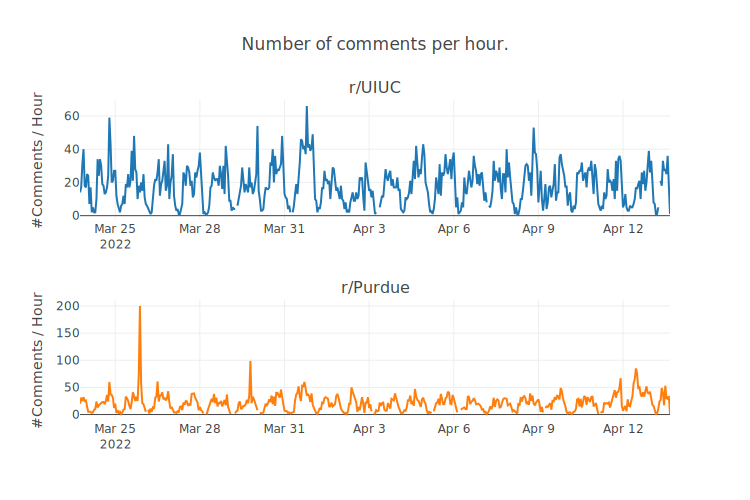

In [63]:
fig = display_subreddit_comment_series(['UIUC', 'Purdue'])

fig.show('svg')
fig.write_image('figs/number_comments_per_hour.svg')

## Total number of comments.

In [345]:
def count_all_comments():
    return pd.DataFrame.from_dict({
        'Comments': all_comments.estimated_document_count()
    }, orient='index').rename(columns={0: 'N'})

count_all_comments()

,N
Comments,147400000


# Regression Analysis
<a id="regression"></a>

In [349]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [375]:
def format_data(threads):
    mask = threads['created_utc'] <= (dt.datetime.now() - dt.timedelta(days=3)).timestamp()
    
    threads = threads[mask].copy()
    
    threads['popular_window'] -= np.average(threads['popular_window'])
    
    return threads

model = smf.ols(
    formula='popular_window ~ num_newcomers',
    data=format_data(thread_master)
).fit(disp=False)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         popular_window   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     39.44
Date:                Thu, 14 Apr 2022   Prob (F-statistic):           3.37e-09
Time:                        04:17:17   Log-Likelihood:                -1719.2
No. Observations:                 154   AIC:                             3442.
Df Residuals:                     152   BIC:                             3449.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6652.3614   1743.087     -3.816      0.000   -1.01e+04   -3208.556
num_newcomers    31.5210      5.019      6.280      0.000      21.605      41.437
==============================================================================
Omnibus:                       16.335   Durbin-Watson:                   0.654
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.120
Skew:                           0.616   Prob(JB):                      0.00142
Kurtosis:                       2.275   Cond. No.                         437.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [393]:
def plot_two_features(df, x, y):
    fig = px.scatter(
        x=df[x].values,
        y=df[y].values
    )
    
    fig.update_layout(
        template='none',
        showlegend=False,
        xaxis_title=x,
        yaxis_title=y,
        height=600,
        width=800
    )
    
    return fig

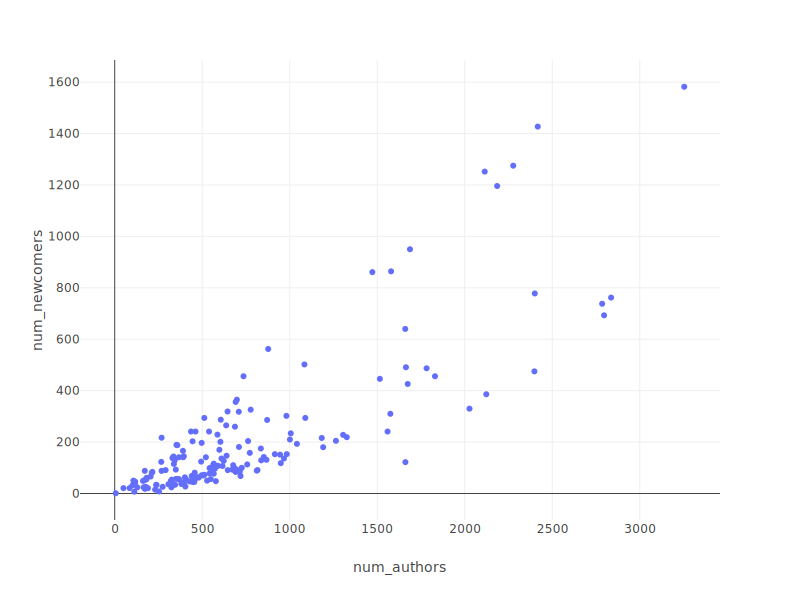

In [394]:
plot_two_features(thread_master, 'num_authors', 'num_newcomers').show('svg')

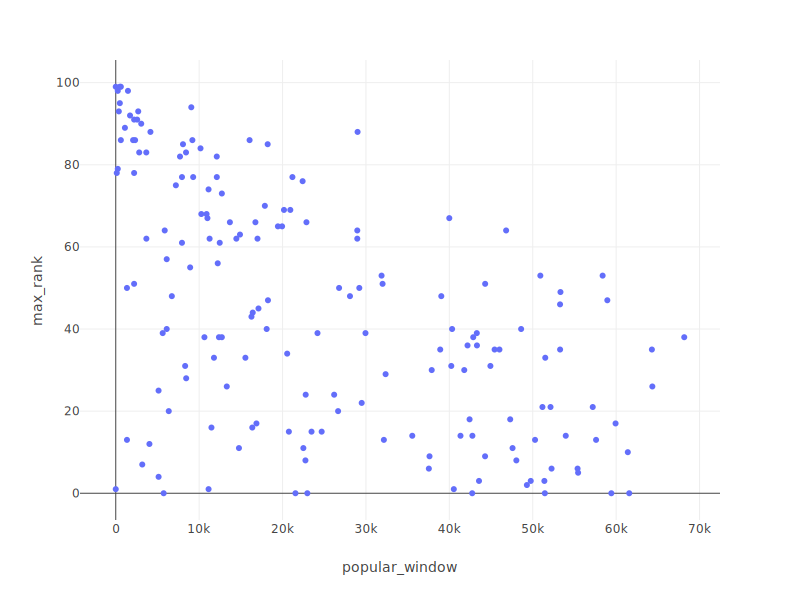

In [395]:
plot_two_features(thread_master, 'popular_window', 'max_rank').show('svg')

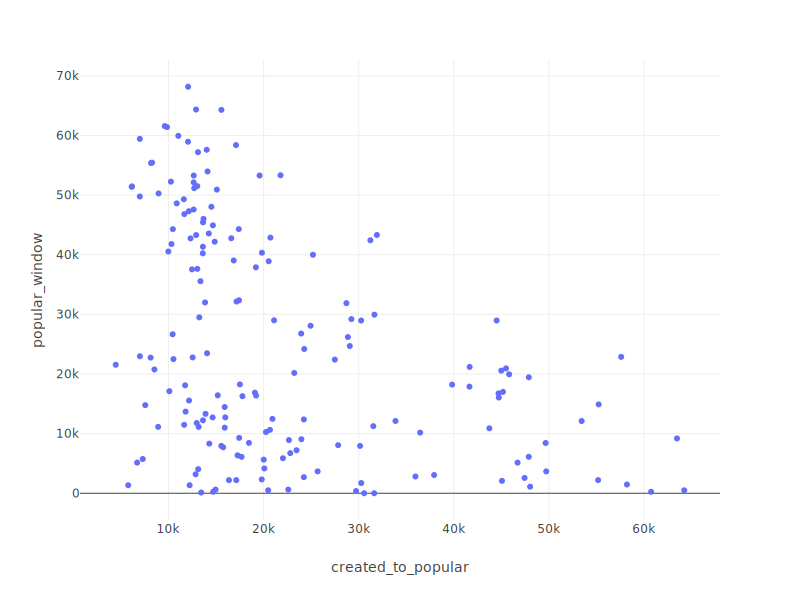

In [396]:
plot_two_features(thread_master, 'created_to_popular', 'popular_window').show('svg')

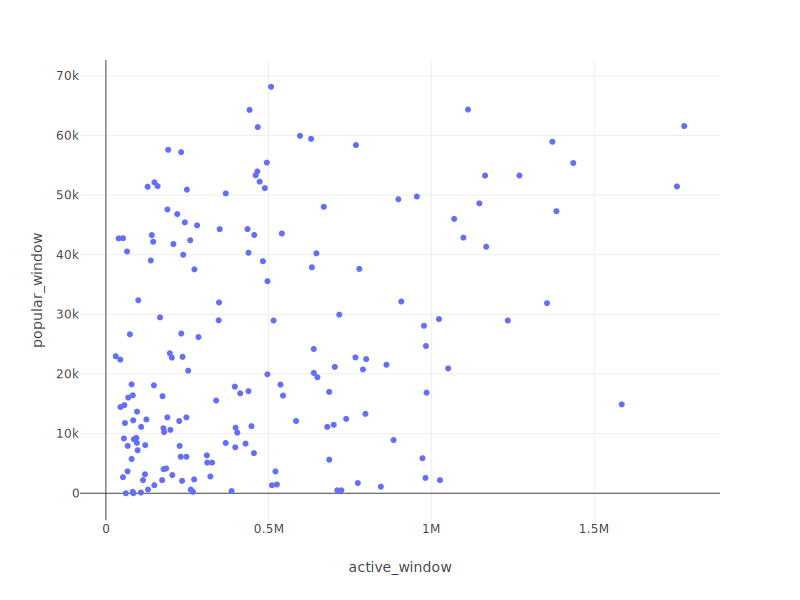

In [397]:
plot_two_features(thread_master, 'active_window', 'popular_window').show('svg')

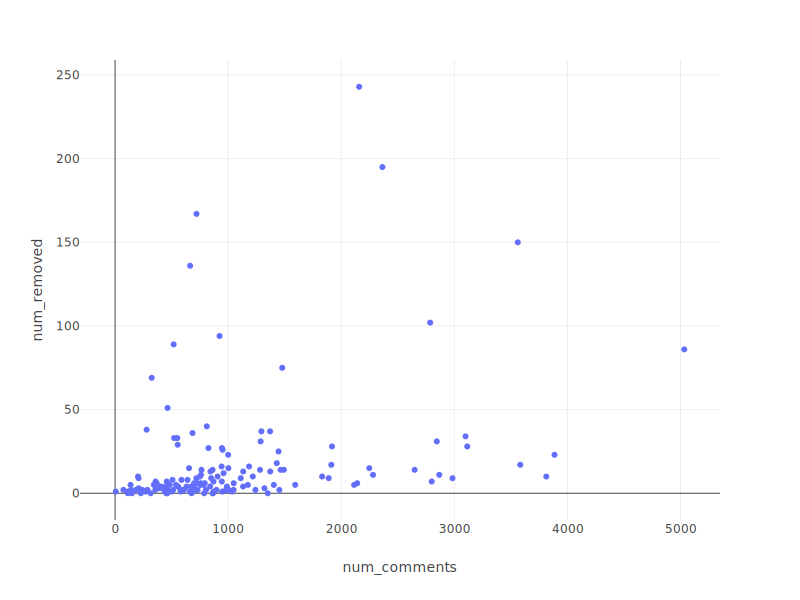

In [402]:
plot_two_features(thread_master, 'num_comments', 'num_removed').show('svg')

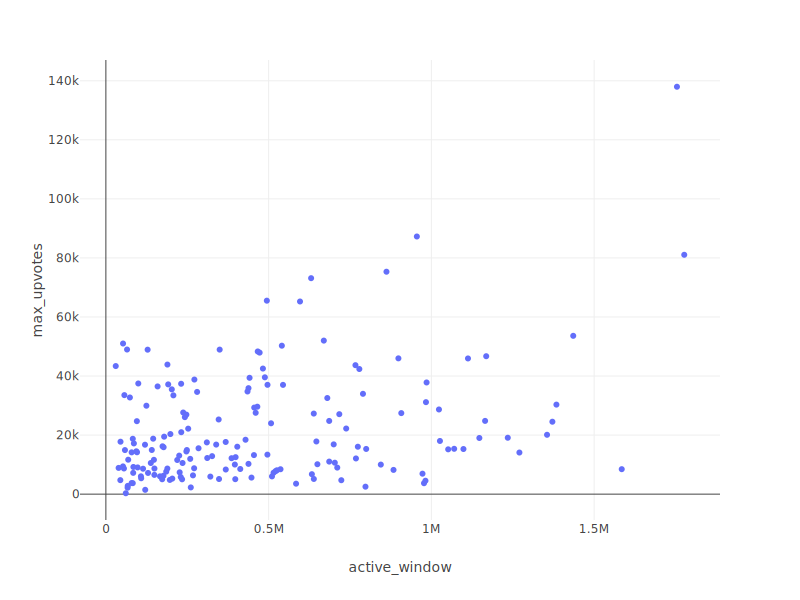

In [403]:
plot_two_features(thread_master, 'active_window', 'max_upvotes').show('svg')